# Statistical Learning - Understanding Canada's Housing Crisis: Drivers of Supply, Demand, and Price

*A Decision Intelligence Analysis of SDG 11 - Sustainable Cities and Communities*

By: Logan Pugsley

## Imports and Setup


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
!apt-get install graphviz libgraphviz-dev pkg-config
!pip install dowhy
!pip install pygraphviz

In [5]:
import pandas as pd
from dowhy import CausalModel
import dowhy.datasets
import numpy as np
import pygraphviz
from IPython.display import Image,display
import seaborn as sns
import matplotlib.pyplot as plt
from causallearn.search.ConstraintBased.PC import pc

## Ingest Data

In [ ]:
df = pd.read_csv('Output.csv')
df.head()

,Date,1-NHPI,2-HAI,3-ConstMat,4-Population,5-Investment,6-ConstMatLagged
0,2024-07-01,0.1,0.488,0.0,0.0,0,0.000000
1,2024-04-01,-0.1,0.506,0.0,0.0,0,0.000000
2,2024-01-01,-0.5,0.518,0.0,0.0,7932778525,-0.030275
3,2023-10-01,-0.8,0.547,0.0,0.0,0,0.000000
4,2023-07-01,-0.9,0.549,0.0,0.0,0,0.000000


#### Measures in Data:
* 1-NHPI --> Average New Housing Price Index
* 2-HAI --> Average Housing Affordability Index
* 3-ConstMat --> Average % Change in Construction Materials Cost
* 4-Population --> Difference in Average Population
* 5-Investment --> Average Total Investment to Housing
* 6-ConstMatLagged --> Lagged Average % Change in Construction Materials Cost


## Correlation Matrix Heatmap

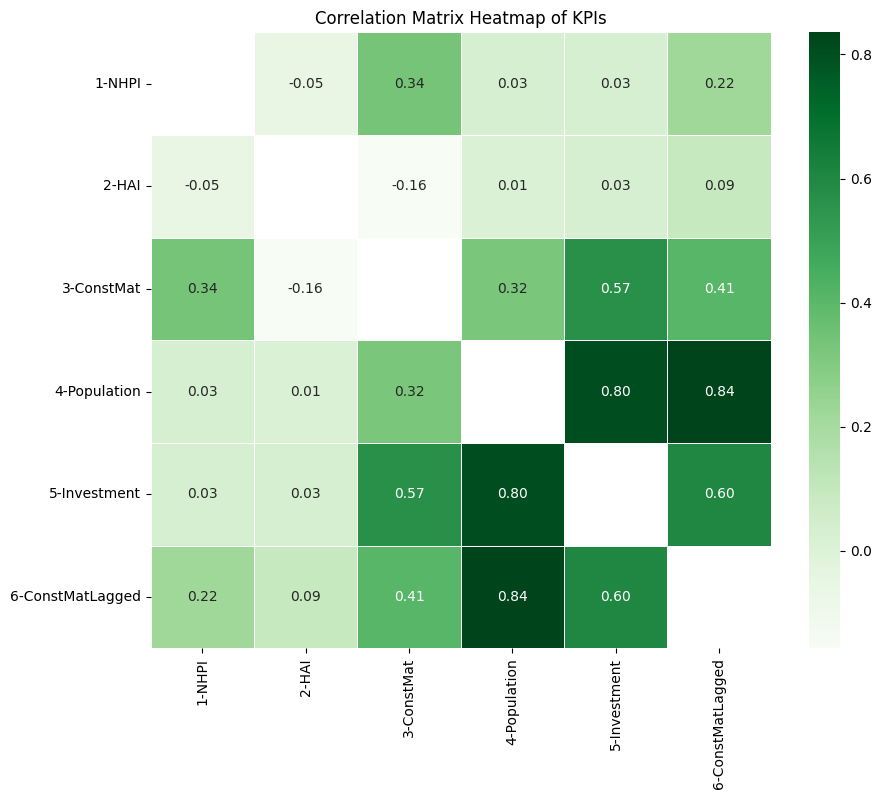

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("Output.csv")  # Adjust filename as needed
df = df.iloc[:, 1:]

# Compute correlation matrix
corr_matrix = df.corr()

# Create a mask for the diagonal elements
mask = np.eye(len(corr_matrix), dtype=bool)  # Creates a True mask for diagonal

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create heatmap with masking
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Greens", linewidths=0.5, mask=mask, cbar=True)

# Titles and labels
plt.title("Correlation Matrix Heatmap of KPIs")
plt.show()

## Determining Models Through Data using ICALiNGAM

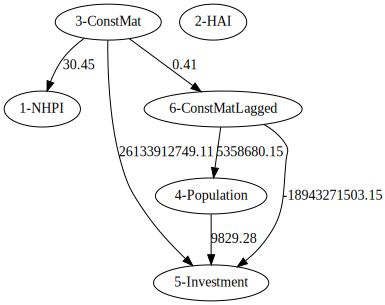

In [ ]:
data = pd.read_csv('Output.csv')
data = data.iloc[:, 1:]
data = data.fillna(method='ffill')


labels = [f'{col}' for i, col in enumerate(data.columns)]

df = data.to_numpy()
from causallearn.search.FCMBased import lingam
model = lingam.ICALiNGAM()
model.fit(df)

from causallearn.search.FCMBased.lingam.utils import make_dot
make_dot(model.adjacency_matrix_, labels=labels)

## Causal Model Creation - Population on Construction Materials

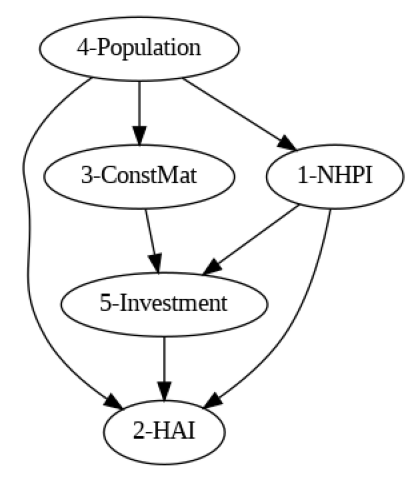

In [ ]:
df = pd.read_csv('Output.csv')
df.head()

graph = """digraph {
    "3-ConstMat" -> "5-Investment";
    "4-Population" -> "2-HAI";
    "5-Investment" -> "2-HAI";
    "1-NHPI" -> "2-HAI";
    "1-NHPI" -> "5-Investment";
    "4-Population" -> "1-NHPI";
    "4-Population" -> "3-ConstMat";
}"""


my_model2 = CausalModel(
    data=df,
    treatment="4-Population",
    outcome="3-ConstMat",
    common_causes=["2-HAI", "5-Investment"],
    instruments="1-NHPI",
    graph=graph)

my_model2.view_model()

## Causal Model Testing and Validation - Population on Construction Materials

### Identify the estimand

In [ ]:
identified_estimand = my_model2.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                      
───────────────(E[3-ConstMat])
d[4-Population]               
Estimand assumption 1, Unconfoundedness: If U→{4-Population} and U→3-ConstMat then P(3-ConstMat|4-Population,,U) = P(3-ConstMat|4-Population,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimate the effect

In [ ]:
causal_effect = my_model2.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(f"Estimated Causal Effect of Identified Estimand: {causal_effect}")

Estimated Causal Effect of Identified Estimand: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                      
───────────────(E[3-ConstMat])
d[4-Population]               
Estimand assumption 1, Unconfoundedness: If U→{4-Population} and U→3-ConstMat then P(3-ConstMat|4-Population,,U) = P(3-ConstMat|4-Population,)

## Realized estimand
b: 3-ConstMat~4-Population
Target units: ate

## Estimate
Mean value: 4.8331170765178455e-08



### Refute

In [ ]:
refute = my_model2.refute_estimate(identified_estimand, causal_effect, method_name="random_common_cause")
print(refute)

Refute: Add a random common cause
Estimated effect:4.8331170765178455e-08
New effect:4.781729273969915e-08
p value:0.94



## Causal Model Creation - Population on Investment

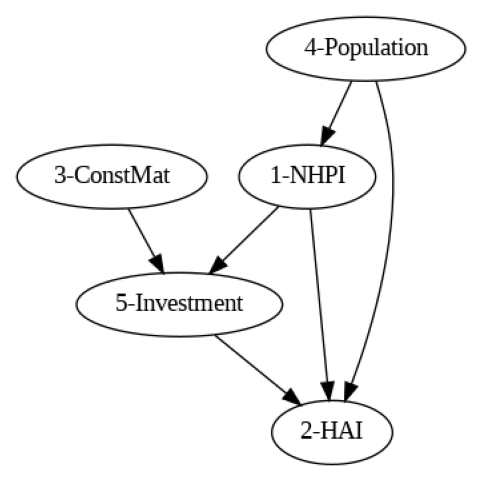

In [ ]:
df = pd.read_csv('Output.csv')
df.head()

graph = """digraph {
    "3-ConstMat" -> "5-Investment";
    "4-Population" -> "2-HAI";
    "5-Investment" -> "2-HAI";
    "1-NHPI" -> "2-HAI";
    "1-NHPI" -> "5-Investment";
    "4-Population" -> "1-NHPI";
}"""


my_model = CausalModel(
    data=df,
    treatment="4-Population",
    outcome="5-Investment",
    common_causes=["2-HAI", "3-ConstMat"],
    instruments="1-NHPI",
    graph=graph)

my_model.view_model()

## Causal Model Testing and Validation - Population on Investment

### Identify the estimand

In [ ]:
identified_estimand = my_model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                        
───────────────(E[5-Investment])
d[4-Population]                 
Estimand assumption 1, Unconfoundedness: If U→{4-Population} and U→5-Investment then P(5-Investment|4-Population,,U) = P(5-Investment|4-Population,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡    d                          d                 ⎤
E⎢─────────(5-Investment)⋅───────────────([1-NHPI])⎥
 ⎣d[1-NHPI]               d[4-Population]          ⎦
Estimand assumption 1, Full-mediation: 1-NHPI intercepts (blocks) all directed paths from 4-Population to 5,-,I,n,v,e,s,t,m,e,n,t.
Estimand assumption 2, First-stage-unconfoundedness: If U→{4-Population} and U→{1-NHPI} then P(1-NHPI|4-Population,U) = P(1-NHPI|4-Population)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{1-NHPI} and U→5-Investm

### Estimate the effect

In [ ]:
causal_effect = my_model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(f"Estimated Causal Effect of Identified Estimand: {causal_effect}")

Estimated Causal Effect of Identified Estimand: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                        
───────────────(E[5-Investment])
d[4-Population]                 
Estimand assumption 1, Unconfoundedness: If U→{4-Population} and U→5-Investment then P(5-Investment|4-Population,,U) = P(5-Investment|4-Population,)

## Realized estimand
b: 5-Investment~4-Population+4-Population*3-ConstMat
Target units: 

## Estimate
Mean value: 8624.737688422203
### Conditional Estimates
__categorical__3-ConstMat
(-0.0313, 0.0]     8026.980220
(0.0, 0.173]      11115.393808
dtype: float64


### Refute

In [ ]:
refute = my_model.refute_estimate(identified_estimand, causal_effect, method_name="random_common_cause")
print(refute)

Refute: Add a random common cause
Estimated effect:8624.737688422203
New effect:8598.065482322574
p value:0.98



## Causal Model Creation - Lagged Construction Materials on NHPI

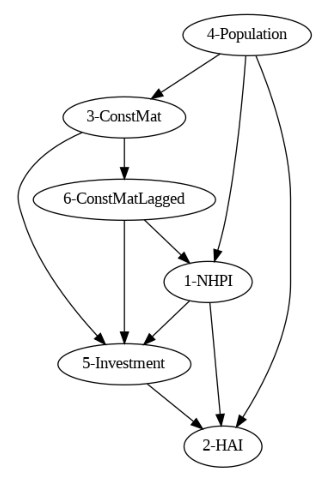

In [15]:
df = pd.read_csv('Output.csv')
df.head()

graph = """digraph {
    "3-ConstMat" -> "5-Investment";
    "3-ConstMat" -> "6-ConstMatLagged";
    "6-ConstMatLagged" -> "5-Investment";
    "6-ConstMatLagged" -> "1-NHPI";
    "4-Population" -> "2-HAI";
    "5-Investment" -> "2-HAI";
    "1-NHPI" -> "2-HAI";
    "1-NHPI" -> "5-Investment";
    "4-Population" -> "1-NHPI";
    "4-Population" -> "3-ConstMat";
}"""


my_model2 = CausalModel(
    data=df,
    treatment="6-ConstMatLagged",
    outcome="1-NHPI",
    common_causes=["4-Population", "5-Investment"],
    # common_causes=["3-ConstMat", "4-Population", "2-HAI", "5-Investment"],
    instruments="1-NHPI",
    graph=graph)

my_model2.view_model()

## Causal Model Testing and Validation - Lagged Construction Materials on NHPI

### Identify the estimand

In [16]:
identified_estimand = my_model2.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                               
───────────────────(E[1-NHPI|3-ConstMat])
d[6-ConstMatLagged]                      
Estimand assumption 1, Unconfoundedness: If U→{6-ConstMatLagged} and U→1-NHPI then P(1-NHPI|6-ConstMatLagged,3-ConstMat,U) = P(1-NHPI|6-ConstMatLagged,3-ConstMat)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimate the effect

In [17]:
causal_effect = my_model2.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(f"Estimated Causal Effect of Identified Estimand: {causal_effect}")

Estimated Causal Effect of Identified Estimand: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                               
───────────────────(E[1-NHPI|3-ConstMat])
d[6-ConstMatLagged]                      
Estimand assumption 1, Unconfoundedness: If U→{6-ConstMatLagged} and U→1-NHPI then P(1-NHPI|6-ConstMatLagged,3-ConstMat,U) = P(1-NHPI|6-ConstMatLagged,3-ConstMat)

## Realized estimand
b: 1-NHPI~6-ConstMatLagged+3-ConstMat
Target units: ate

## Estimate
Mean value: 10.055623785427192



### Refute

In [19]:
refute = my_model2.refute_estimate(identified_estimand, causal_effect, method_name="random_common_cause")
print(refute)

Refute: Add a random common cause
Estimated effect:10.055623785427192
New effect:10.544157676586575
p value:0.98

